# Supervised learning

This notebook will test supervised learning, and more specifically LinearRegression, and evaluate its performance

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading of the train and test sets defined in 3-scaling
df_train = pd.read_csv("../data/train_normalised.csv")
df_test = pd.read_csv("../data/test_normalised.csv")


For supervised learning, we will only keep labelled data, which is what is done in the following part

In [8]:
target = "YieldStrength"

# Definition of X_train and y_train
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test  = df_test.drop(columns=[target])
y_test  = df_test[target]

# Drop columns with more than 90% NaN in X_train
nan_ratio = X_train.isna().mean()
cols_to_drop = nan_ratio[nan_ratio > 0.9].index
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

print(f"Dropped columns with >90% NaN: {list(cols_to_drop)}")

# Masks for labelled data
mask_labelled   = y_train.notna()

X_train_labelled   = X_train.loc[mask_labelled].copy()
y_train_labelled   = y_train.loc[mask_labelled].copy()


Dropped columns with >90% NaN: ['PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']


We will here test 2 different supervised learning method : 
* **Random Forest Regressor**
* **Gradient Boosting Regressor**

We will evaluate their performance based on :
* **Graphs** : How close the predicted values of the YieldStrength are to the observed values of the YieldStrength; 
* **R²** : the closest to 1, the better the model, as it means that the model encapsulate the variance well
* **Mean Squared Error** : the smaller the better, as it will mean that great errors rarely exist
* **Mean Absolute Error** : the smaller the better, it shows how close the model predicts the Yield Strength

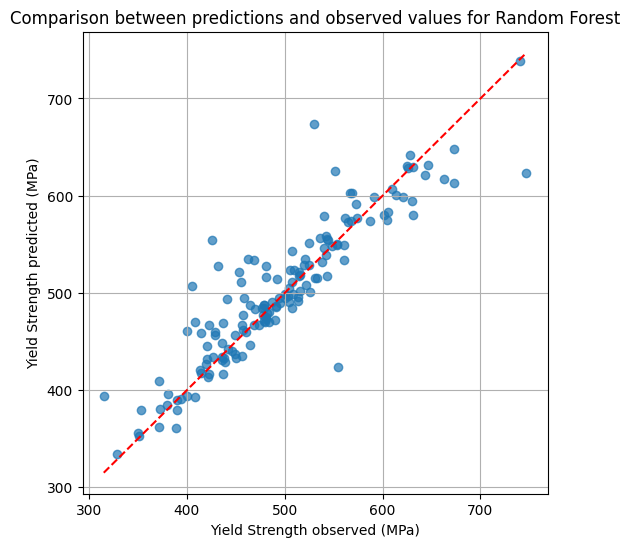

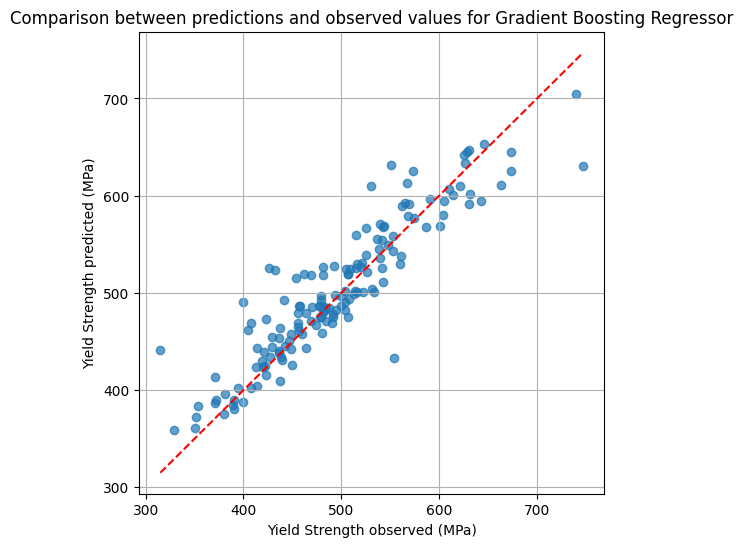

,MAE,MSE,R²
Gradient Boosting Regressor,22.831967,32.845145,0.830643
Random Forest,21.460015,34.067566,0.817803


In [9]:
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300, 
        random_state=42
        ),
    "Gradient Boosting Regressor": HistGradientBoostingRegressor(
        learning_rate=0.1, 
        max_iter=300, 
        max_depth=6, 
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
        )
}

results = {}
for name, model in models.items():
    model.fit(X_train_labelled, y_train_labelled)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": rmse, "R²": r2}
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Yield Strength observed (MPa)")
    plt.ylabel("Yield Strength predicted (MPa)")
    plt.title(f"Comparison between predictions and observed values for {name}")
    plt.grid(True)
    plt.show()

pd.DataFrame(results).T.sort_values("R²", ascending=False)


Fine-tuning of the two models, to try and better the results :

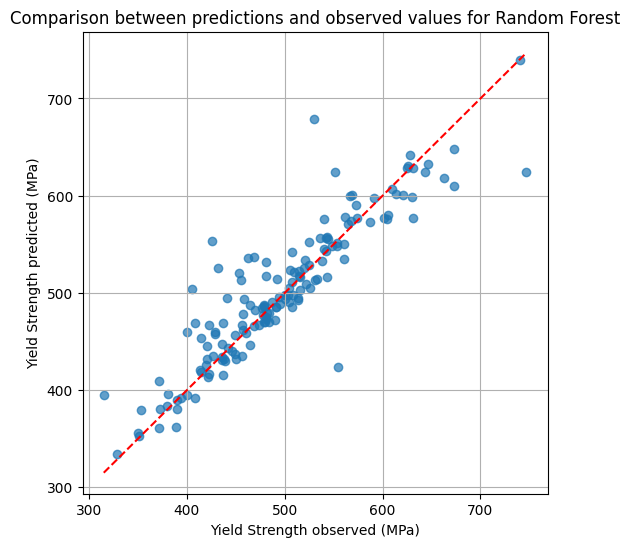

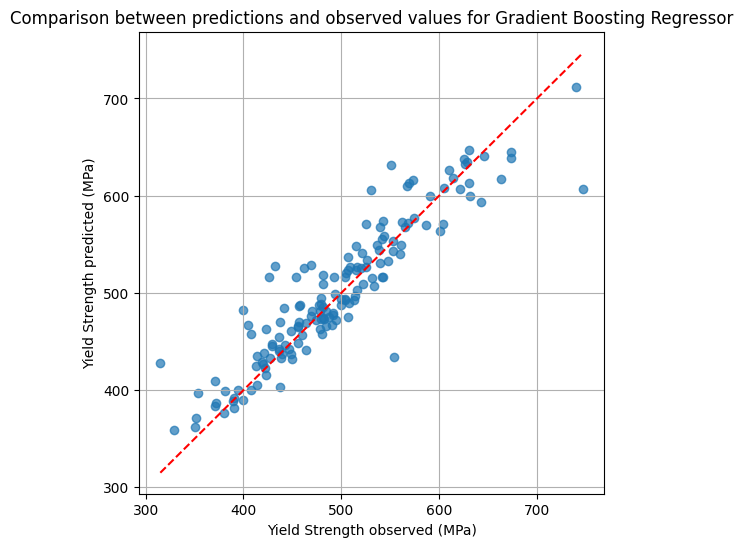

,MAE,MSE,R²
Gradient Boosting Regressor,22.009919,32.130143,0.837936
Random Forest,21.346230,34.054368,0.817944


In [10]:
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, # Testing with less trees : increases rapidity, but maintains stability while bettering the results 
        random_state=42
        ),
    "Gradient Boosting Regressor": HistGradientBoostingRegressor(
        learning_rate=0.15, # Increasing the learning rate
        max_iter=600, # Increasing the number of iterations
        max_depth=5, 
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
        )
}

results = {}
for name, model in models.items():
    model.fit(X_train_labelled, y_train_labelled)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": rmse, "R²": r2}
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Yield Strength observed (MPa)")
    plt.ylabel("Yield Strength predicted (MPa)")
    plt.title(f"Comparison between predictions and observed values for {name}")
    plt.grid(True)
    plt.show()

pd.DataFrame(results).T.sort_values("R²", ascending=False)

The results being somewhat similar, we'll choose the Random Forest predictor to be able to explain the feature importance.

Top 10 Feature Importances:
       Feature  Importance
13         UTS    0.744536
18    Hardness    0.024584
12          Sb    0.021287
14  Elongation    0.017663
0            C    0.013217
8            N    0.012013
7            O    0.011673
16  CharpyTemp    0.010668
30   HeatInput    0.009512
26          Al    0.009329


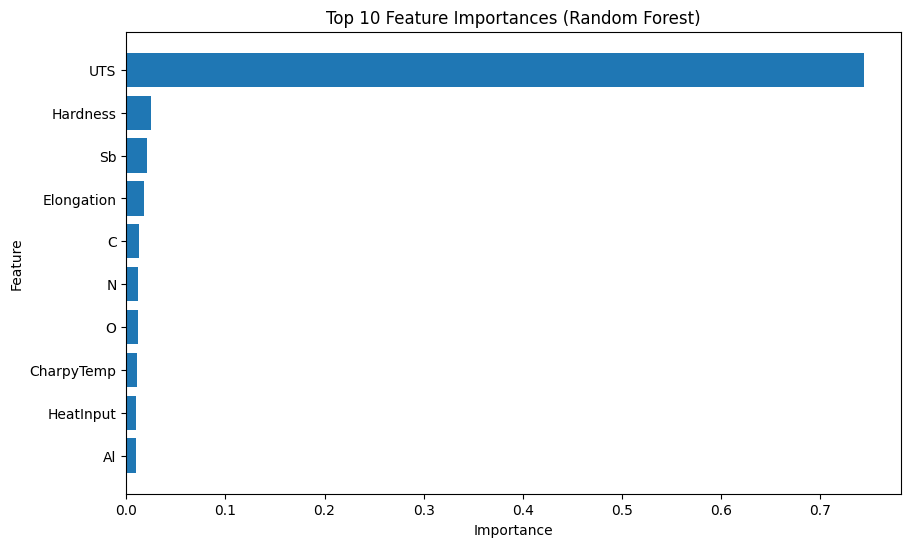

In [12]:
# Get feature importances from the Random Forest model
importances = models["Random Forest"].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Feature Importances:")
print(importance_df.head(10))

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()